# Quantum Simulation

This project is meant to show how a quantum simulation could be performed using quantum computing. In practice, many of the functions used here cannot be used (like using the statevectors). Nonetheless, with a stable enough source of qubits, all of these steps could be implemented using clever methods (like measuring the phases in the bloch sphere in each iteration to calculate the actual state instead of just the probability amplitude). 

Nonetheless, this project is meant to provide pragmatic methods that can usually be implemented when working with simulation-backends.

## From $\ket{0}$ 's and $\ket{1}$ 's to $\psi(x)$:

We discretize our spatial dimension using each different state as a point in space (with the coefficient being the value of the wavefunction at this point.)

In [20]:
import numpy as np
import qiskit as q
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
%matplotlib inline

# hetlper function
def dict_to_np(state_dict: dict, n: int) -> np.ndarray:
    state_arr = np.zeros(2**n, dtype=complex)
    for elem in state_dict:
        state_arr[int(elem, 2)] = state_dict[elem]
    return state_arr


## Setup initial parameters

We want to discretize our 'grid' for the wavefunction. If we have $k$ quibts, our grid will be able to have $2^k$ points (corresponding to each possible basis state)

In [10]:
n = 7 # number of qubits
k0, m = 50, 1e-1 # initial state momentum parameter, mass parameter
del_t, t_tot=1e-1, 15 # time step, total time
xlim = 1 # spatial range
ts = np.linspace(0, t_tot, int(t_tot/del_t))
domain = np.linspace(-xlim,xlim, 2**n)

## Define the gates we will use
For a time independent Hamiltonian $\hat{H}$, without much rigour we can see that 
$$
    \ket{\psi(t)} = e^{-i\hat{H}t} \ket{\psi_0}
$$
satisfies the Schrödinger equation

And so we discretize!

In [22]:
free_hamilt_mat = np.diag(np.exp(-1j*del_t*domain**2/2/m)) # free Hamiltonian matrix
free_hamilt = UnitaryGate(free_hamilt_mat, label=r'H_0') # free Hamiltonian gate corresponding to free Hamiltonian matrix

# V =  x**2/2
# poten_hamilt = UnitaryGate(np.diag(np.exp(-1j*del_t*V(domain)/2)), label=r'H_V')

func = lambda x: np.exp(-(4*x)**2)*np.exp(1j* k0*x) # initial state function \psi(x, t=0)


Now we proceed to initialize state and normalize it. We can visualize it using standard functions from qiskit (e.g., `plot_bloch_multivector`)

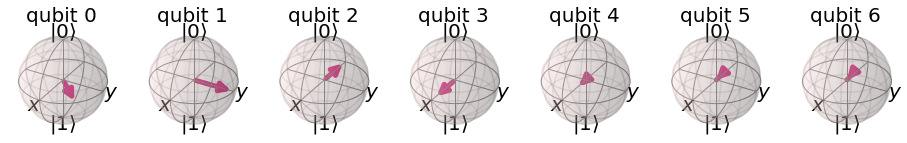

In [21]:
init_state = func(domain)
N = np.sqrt(np.sum(np.abs(init_state)**2))
init_state = init_state/N
max = np.max(np.abs(init_state))
plot_bloch_multivector(init_state)

Next we proceed to create the circuit that represents one iteration of our time evolution. In order to add new (pre-made) elements to our circuit, we will use `compose` and `append` to show these two examples.

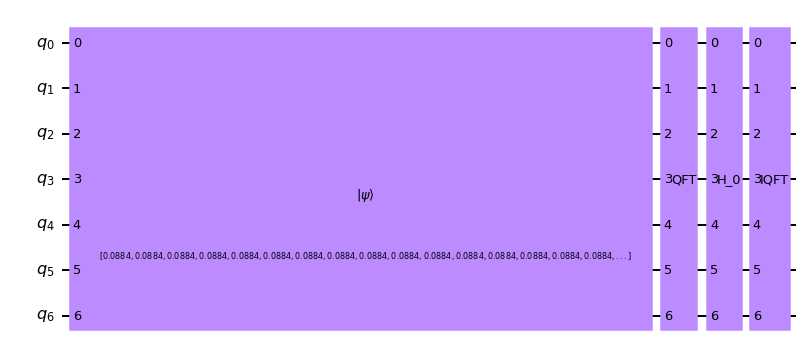

In [24]:
def create_sim_circuit(init_state: np.ndarray) -> QuantumCircuit:
    sim_circuit = q.QuantumCircuit(n)
    sim_circuit.initialize(init_state)
    sim_circuit.append(QFT(num_qubits=n), range(n)) # append method
    sim_circuit = sim_circuit.compose(free_hamilt, range(n)) # compose method
    sim_circuit.compose(QFT(num_qubits=n).inverse(), range(n), inplace=True) # inplace=True compose method
    """all methods are practically equivalent"""
    return sim_circuit

temp_circ = create_sim_circuit(np.ones(2**n)/np.sqrt(2**n))
temp_circ.draw('mpl')
    

_Note:_ An easy generalization for a hamiltonian with potential naturally arises from this method, with the exponential-of-potential term to be implemented outside of the Fourier Space. Its implementation is left as an exercise. 

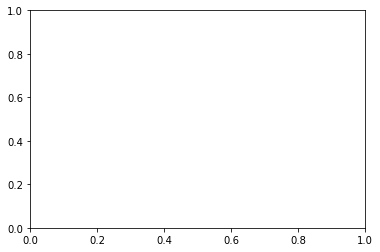

In [26]:
for i, t in enumerate(ts):
    plt.plot(domain, np.abs(init_state))
    circ = create_sim_circuit(init_state)
    state = q.execute(circ, q.Aer.get_backend('statevector_simulator')).result().get_statevector() # statevector simulator

    init_state = dict_to_np(state.to_dict(), n) # convert statevector to numpy array to implement in next time step
                                                # this step is only viable in simulation, but can be replaced 
                                                # by more complicated measurements in real quantum computers
    # plt.plot(domain, V(domain), color='darkorange', alpha=0.6) # plot potential if used in simulation
    plt.grid(ls='--')
    plt.axis([-xlim, xlim, 0, 1.2*max])
    plt.savefig(f'frames/q_sim_frame_{i}.png')
    plt.cla()
    # print(init_state*init_state) # check normalization


And then we can proceed to animate with our favorite `animate` function (all images of the states are already saved in a folder __frames__)